<a href="https://colab.research.google.com/github/mnaveed8167/Deep-Learning/blob/main/Assignment2_Semantic-Segmentationipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Required Libraries
# !pip install -U albumentations>=0.3.0 --user 
!pip install segmentation-models
!pip install dataframe_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 4.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
import segmentation_models as sm
import albumentations as Alb

In [ ]:
x_train_path = '/content/drive/MyDrive/Computer Vision Assignment/A2 Semantic segmentation/dataset1/images_prepped_train'
y_train_path = '/content/drive/MyDrive/Computer Vision Assignment/A2 Semantic segmentation/dataset1/annotations_prepped_train'
x_test_path = '/content/drive/MyDrive/Computer Vision Assignment/A2 Semantic segmentation/dataset1/images_prepped_test'
y_test_path = '/content/drive/MyDrive/Computer Vision Assignment/A2 Semantic segmentation/dataset1/annotations_prepped_test'

In [ ]:
# classes for data loading and preprocessing
class Dataset:
    def __init__(
            self, 
            images_dir, 
            masks_dir,  
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [0,1,2,3,4,5,6,7,8,9,10,11]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [ ]:

def visualize(sv,dest_path,model_name,**images):
    n = len(images)
    r=np.ceil(n/4)
    c=np.ceil(n/4)
    if (c==1.0):
      c=3
    plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(r, c, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if sv==1:
      plt.savefig(dest_path+model_name)
    plt.show()

def Visualize_overlay_mask(sv,dest_path,model_name,image,mask):

  #plt.figure(figsize=(25, 16))

  fig,ax =plt.subplots()
  plt.xticks([])
  plt.yticks([])
  ax.imshow(image)
  ax.imshow(mask,alpha=0.5)
  plt.title(model_name.title())
  if sv==1:
    plt.savefig(dest_path+model_name)
  plt.show()


def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    


In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [

        Alb.HorizontalFlip(p=0.5),

        Alb.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        Alb.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        Alb.RandomCrop(height=320, width=320, always_apply=True),

        Alb.IAAAdditiveGaussianNoise(p=0.2),
        Alb.IAAPerspective(p=0.5),

        Alb.OneOf(
            [
                Alb.CLAHE(p=1),
                Alb.RandomBrightness(p=1),
                Alb.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        Alb.OneOf(
            [
                Alb.IAASharpen(p=1),
                Alb.Blur(blur_limit=3, p=1),
                Alb.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        Alb.OneOf(
            [
                Alb.RandomContrast(p=1),
                Alb.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        Alb.Lambda(mask=round_clip_0_1)
    ]
    return Alb.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        Alb.PadIfNeeded(320, 320)
    ]
    return Alb.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        Alb.Lambda(image=preprocessing_fn),
    ]
    return Alb.Compose(_transform)

In [ ]:
#import segmentation_models as sm
import tensorflow as tf
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')

In [ ]:
# network parameters
BACKBONE = 'inceptionv3'
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 10
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 12
activation =  'softmax'

model=sm.Unet(BACKBONE, input_shape=(320,320,3),classes=n_classes, activation=activation,encoder_freeze=True)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# custom metrics 
import keras.backend as bK
def dice_coef(y_true, y_pred, smooth=1):
  inter_section = bK.sum(y_true * y_pred, axis=[1,2,3])
  uni_on = bK.sum(y_true, axis=[1,2,3]) + bK.sum(y_pred, axis=[1,2,3])
  dice = bK.mean((2. * inter_section + smooth)/(uni_on + smooth), axis=0)
  return dice
def sensitivity(y_true, y_pred): 
    truepositives = bK.sum(bK.round(bK.clip(y_true * y_pred, 0, 1)))
    possiblepositives = bK.sum(bK.round(bK.clip(y_true, 0, 1)))
    return truepositives / (possiblepositives + bK.epsilon())
def specificity(y_true, y_pred):
    truenegatives = bK.sum(bK.round(bK.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possiblenegatives = bK.sum(bK.round(bK.clip(1 - y_true, 0, 1)))
    return truenegatives / (possiblenegatives + bK.epsilon())

In [ ]:
# training settings
optimizer_used = tf.keras.optimizers.Adam(LR)
loss_cat = sm.losses.categorical_focal_dice_loss 
#loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics_perf = [dice_coef,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy',sensitivity,specificity]
#metrics=[tf.keras.metrics.Accuracy()]
# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer_used, loss_cat, metrics_perf)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_path, 
    y_train_path, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
train_X, val_X = train_test_split(train_dataset,test_size=0.2, random_state=0)
train_dataloader = Dataloder(train_X, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(val_X, batch_size=1, shuffle=False)
file_path='/content/drive/MyDrive/Colab Notebooks/Assignment2/results/'
callbacks = [
    keras.callbacks.ModelCheckpoint(file_path+'InceptionV3_fine_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min',min_delta=0.001)]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=10, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


36/36 [==============================] - 37s 462ms/step - loss: 0.8031 - dice_coef: 0.4221 - iou_score: 0.1800 - f1-score: 0.2228 - accuracy: 0.5278 - sensitivity: 0.4724 - specificity: 0.9926 - val_loss: 0.8927 - val_dice_coef: 0.5181 - val_iou_score: 0.1543 - val_f1-score: 0.1996 - val_accuracy: 0.5043 - val_sensitivity: 0.5934 - val_specificity: 0.9555 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 14s 380ms/step - loss: 0.6729 - dice_coef: 0.6330 - iou_score: 0.3047 - f1-score: 0.3671 - accuracy: 0.6433 - sensitivity: 0.7348 - specificity: 0.9876 - val_loss: 0.8202 - val_dice_coef: 0.5852 - val_iou_score: 0.1848 - val_f1-score: 0.2373 - val_accuracy: 0.5818 - val_sensitivity: 0.6751 - val_specificity: 0.9642 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 14s 384ms/step - loss: 0.6233 - dice_coef: 0.6720 - iou_score: 0.3261 - f1-score: 0.3948 - accuracy: 0.6613 - sensitivity: 0.7700 - specificity: 0.9822 - val_loss: 0.7956 - val_dice_coef: 0.5792 

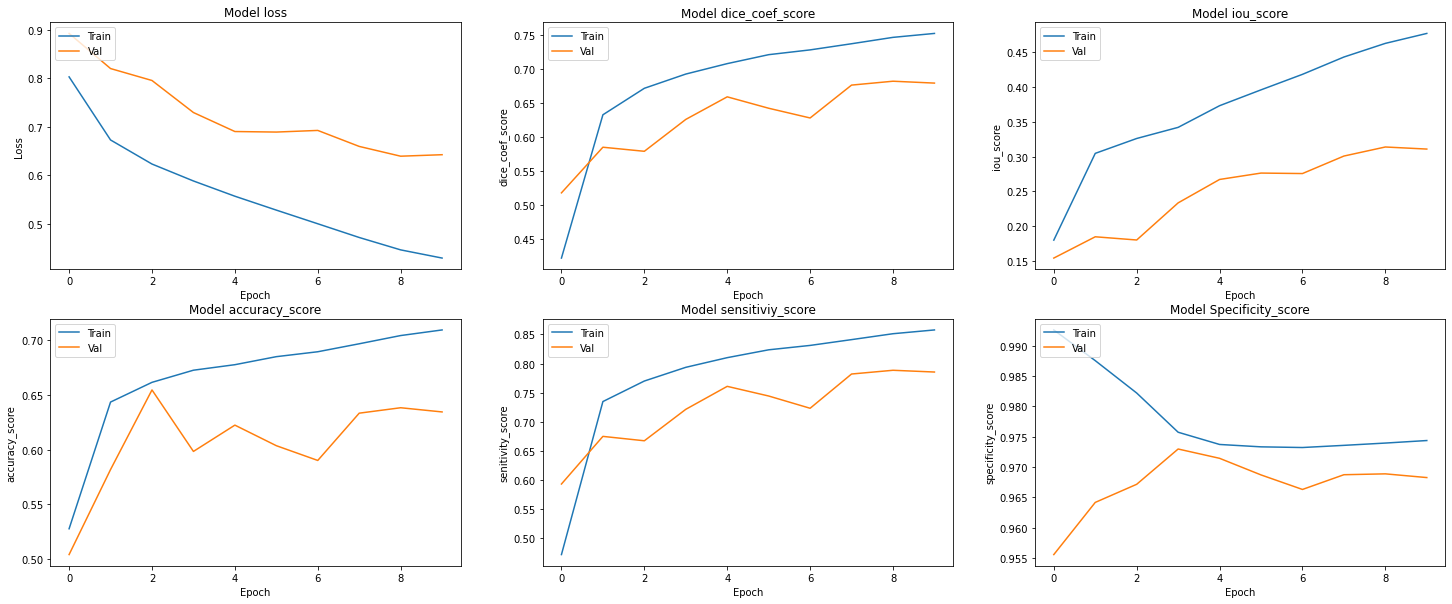

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(25, 10))


#Plot training & validation loss values
plt.subplot(231)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(np.argmin(model.history.history['val_loss']), np.min(model.history.history['val_loss']), marker="x", color="r", label="best model")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(232)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef_score')
plt.ylabel('dice_coef_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(233)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#

plt.subplot(234)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy_score')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#

plt.subplot(235)
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model sensitiviy_score')
plt.ylabel('senitivity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(236)
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity_score')
plt.ylabel('specificity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(file_path+'aug_densenet_trans_loss')
plt.show()


In [ ]:
test_dataset = Dataset(
    x_test_path, 
    y_test_path, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
scores = model.evaluate_generator(test_dataloader)
import pandas as pd
import dataframe_image as dfi
s = pd.Series({'Model': 'InceptionV3 with Augmenatation', 
               'CFD-Loss': scores[0], 
               'dice-coeff': scores[1],
               'IOU score':scores[2],
               'F1-Score':scores[3],
               'Accuracy':scores[4],
               'Sensitivity':scores[5],
               'Specificity':scores[6]})
dataframe=pd.DataFrame(s)
dataframe_styled = dataframe.style.background_gradient()
dataframe.set_axis(['values'], axis=1, inplace=True)
dfi.export(dataframe_styled,"aug-InceptionV3-freeze.png",table_conversion="matplotlib")
dataframe.head(8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


,values
Model,Densenet121 with Augmenatation
CFD-Loss,0.484699
dice-coeff,0.830409
IOU score,0.456678
F1-Score,0.545533
Accuracy,0.835957
Sensitivity,0.833468
Specificity,0.985634


[12  2 95 66]
1/1 [==============================] - 0s 49ms/step


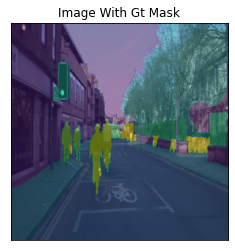

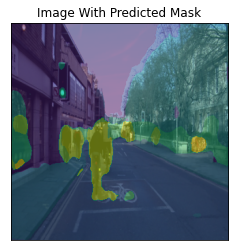

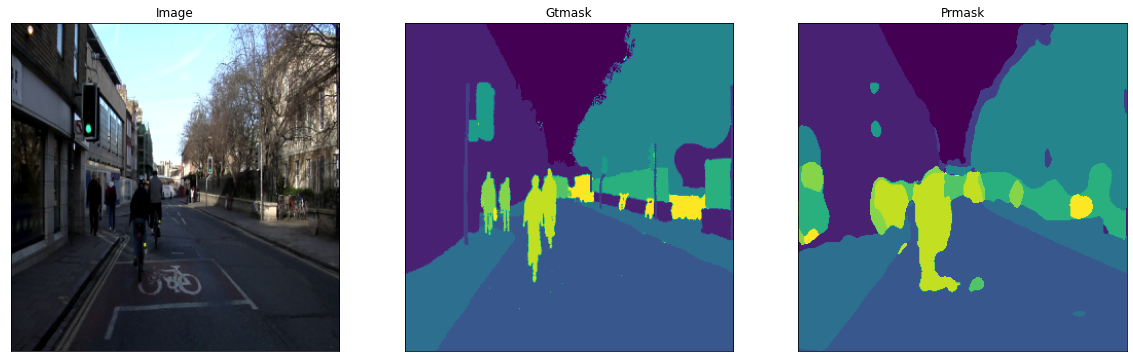

1/1 [==============================] - 0s 28ms/step


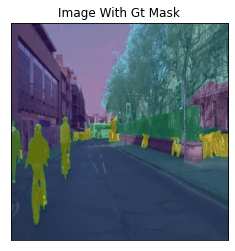

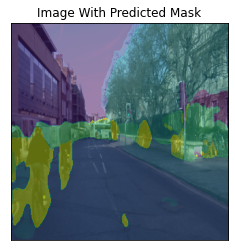

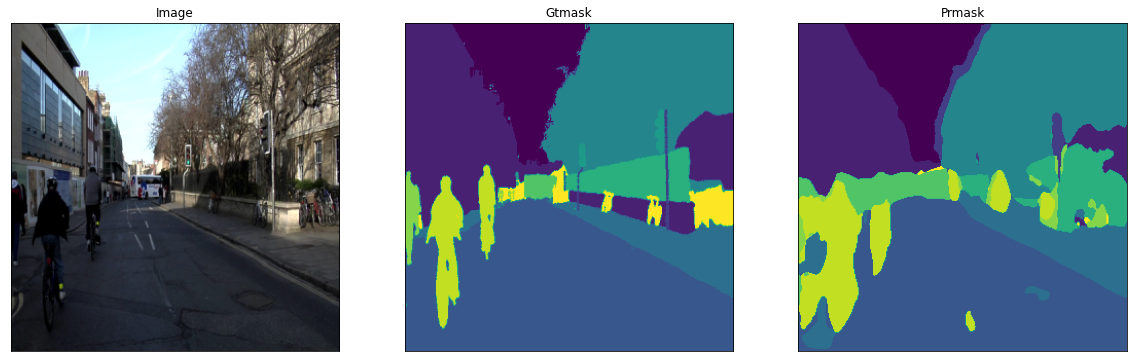

1/1 [==============================] - 0s 29ms/step


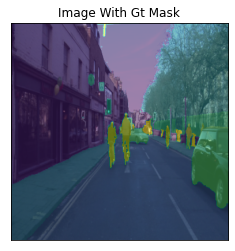

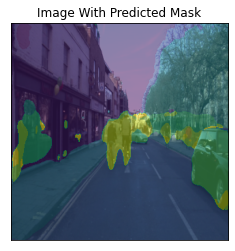

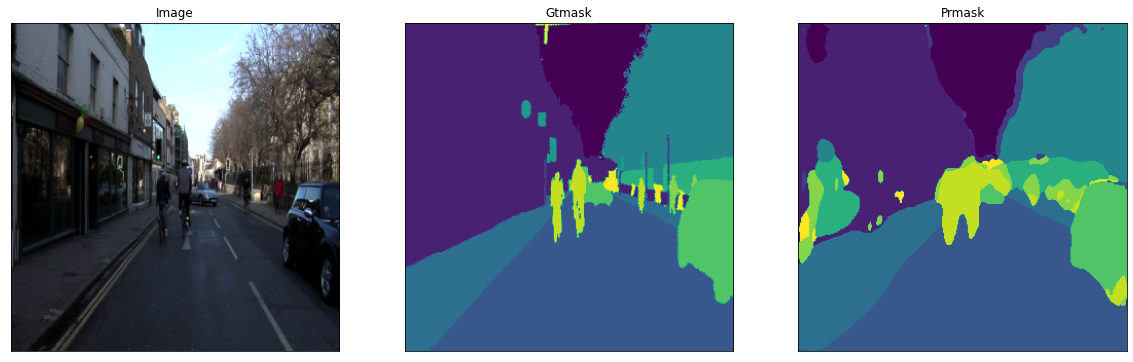

1/1 [==============================] - 0s 28ms/step


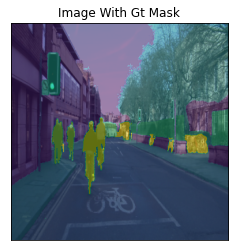

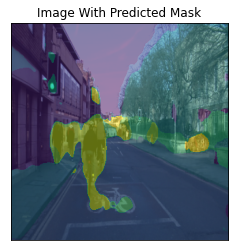

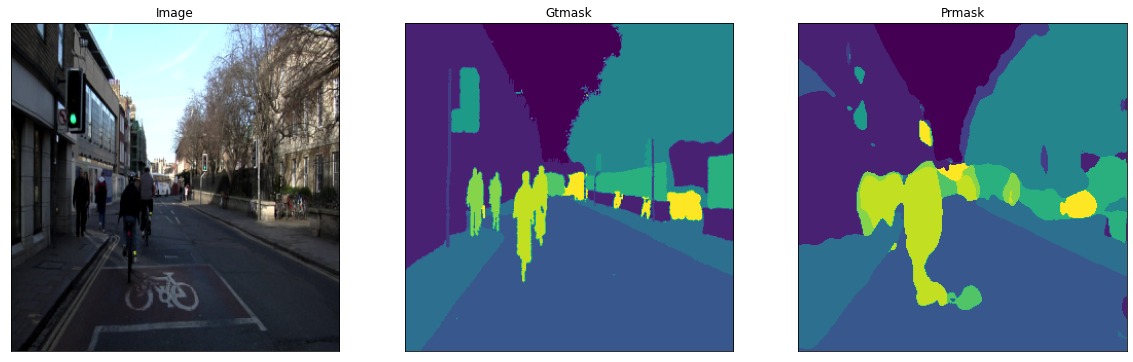

In [ ]:
n = 4
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
print(ids)

for i in ids:
    
    images, get_mask = test_dataset[i]
    images = np.expand_dims(images, axis=0)
    prmask = model.predict(images)
    Gtmask=np.argmax(get_mask.squeeze(),axis=-1)
    Prmask=np.argmax(prmask.squeeze(),axis=-1)
    Visualize_overlay_mask(1,file_path,'Image with GT mask',
      image = denormalize(images.squeeze()),
      mask = Gtmask)
    Visualize_overlay_mask(1,file_path,'Image with predicted mask',
        image = denormalize(images.squeeze()),
        mask=Prmask)
    visualize(1,file_path,'InceptionV3-CFD',
        image = denormalize(images.squeeze()),
        GTmask=Gtmask,
        Prmask=Prmask
      
    )